# 5.5 卷积神经网络（LeNet）

参考文献：参考文献

[1] LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.

在多层感知机的从零开始实现里我们构造了一个含单隐藏层的多层感知机模型来对Fashion-MNIST数据集中的图像进行分类。每张图像高和宽均是28像素。我们将图像中的像素逐行展开，得到长度为784的向量，并输入进全连接层中。然而，这种分类方法有一定的局限性。

* 图像在同一列邻近的像素在这个向量中可能相距较远。它们构成的模式可能难以被模型识别。
* 对于大尺寸的输入图像，使用全连接层容易造成模型过大。假设输入是高和宽均为1000像素的彩色照片（含3个通道）。即使全连接层输出个数仍是256，该层权重参数的形状是3,000,000×256：它占用了大约3 GB的内存或显存。这带来过复杂的模型和过高的存储开销。

卷积层尝试解决这两个问题。一方面，卷积层保留输入形状，使图像的像素在高和宽两个方向上的相关性均可能被有效识别；另一方面，卷积层通过滑动窗口将同一卷积核与不同位置的输入重复计算，从而避免参数尺寸过大。

卷积神经网络就是含卷积层的网络。本节里我们将介绍一个早期用来识别手写数字图像的卷积神经网络：LeNet [1]。这个名字来源于LeNet论文的第一作者Yann LeCun。LeNet展示了通过梯度下降训练卷积神经网络可以达到手写数字识别在当时最先进的结果。这个奠基性的工作第一次将卷积神经网络推上舞台，为世人所知。LeNet的网络结构如下图所示。

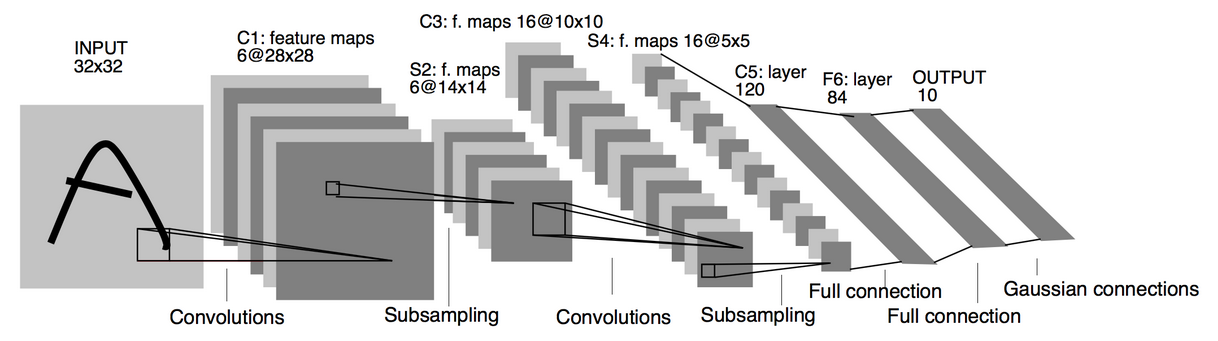

## 5.5.1 LeNet模型

LeNet分为卷积层块和全连接层块两个部分。

卷积层块里的基本单位是卷积层后接最大池化层：卷积层用来识别图像里的空间模式，如线条和物体局部，之后的最大池化层则用来降低卷积层对位置的敏感性。卷积层块由两个这样的基本单位重复堆叠构成。在卷积层块中，每个卷积层都使用5×5的窗口，并在输出上使用sigmoid激活函数。第一个卷积层输出通道数为6，第二个卷积层输出通道数则增加到16。这是因为<font color='red'>第二个卷积层比第一个卷积层的输入的高和宽要小，所以增加输出通道使两个卷积层的参数尺寸类似，也就是说为了更多的保留上一层的信息，卷积池化后feature map是原来1/2，如果通道数不变，会丢失很多有效信息。</font>。卷积层块的两个最大池化层的窗口形状均为2×2，且步幅为2。由于池化窗口与步幅形状相同，池化窗口在输入上每次滑动所覆盖的区域互不重叠。

卷积层块的输出形状为(批量大小, 通道, 高, 宽)。当卷积层块的输出传入全连接层块时，全连接层块会将小批量中每个样本变平（flatten）。也就是说，全连接层的输入形状将变成二维，其中第一维是小批量中的样本，第二维是每个样本变平后的向量表示，且向量长度为通道、高和宽的乘积。全连接层块含3个全连接层。它们的输出个数分别是120、84和10，其中10为输出的类别个数。

https://blog.csdn.net/beautiful77moon/article/details/101724814

In [2]:
#通过Sequential实现LeNet模型

import time
import torch
from torch import nn,optim

import sys
sys.path.append('..')
import d2lzh_pytorch as d2l
device=torch.device('cuda' if torch.cuda.is_available()
                           else 'cpu')

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(1,6,5),#in_channels,out_channels,kernel_size
            nn.Sigmoid(),
            nn.MaxPool2d(2,2),#kernel_size,stride
            nn.Conv2d(6,16,5),
            nn.Sigmoid(),
            nn.MaxPool2d(2,2)
        )
        self.fc=nn.Sequential(
            nn.Linear(16*4*4,120),#input,output
            nn.Sigmoid(),
            nn.Linear(120,84),
            nn.Sigmoid(),
            nn.Linear(84,10)
        )
    
    def forward(self,img):
        feature=self.conv(img)#进行前向计算
        output=self.fc(feature.view(img.shape[0],-1))#img.shape[0]为样本数
        return output

In [10]:
net=LeNet()
print(net)
print(list(net.parameters())[0].device)

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
cpu


可以看到，在卷积层块中输入的高和宽在逐层减小。卷积层由于使用高和宽均为5的卷积核，从而将高和宽分别减小4，而池化层则将高和宽减半，但通道数则从1增加到16。全连接层则逐层减少输出个数，直到变成图像的类别数10。

## 5.5.2 获取数据和训练模型

In [5]:
#使用Fashion-MNIST作为训练数据集

batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)


In [11]:
def evaluate_accuracy(data_iter,net,device=None):
    if device is None and isinstance(net,torch.nn.Module):
        #判断net是torch.nn.Module类型还是自定义类型
        #如果没指定device就使用net的device
        device=list(net.parameters())[0].device
    acc_sum,n=0.0,0
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(net,torch.nn.Module):
                net.eval()#评估模式，关闭dropout
# moving CPU Tensors with pinned memory to CUDA devices.
                acc_sum+=(net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().item()
                net.train()#改回训练模式
            else: #自定义的模型，不考虑GPU
                if('is_training'in net.__code__.co_varnames):
                #如果有‘is_training’这个参数
                    acc_sum+=(net(X,is_training=False).argmax(dim=1)==y).float().sum().item()
                else:
                    acc_sum+=(net(X).argmax(dim=1)==y).float().sum().item()
            n+=y.shape[0]
    return acc_sum/n

In [1]:
# 对train_ch3函数略作修改，确保计算使用的数据和模型同在内存或显存上。
def train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs):
    net=net.to(device)
    print('training on',device)
    loss=torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum=0.0
        train_acc_sum=0.0
        n=0
        batch_count=0
        start=time.time()
        
        for X,y in train_iter:
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            loss_=loss(y_hat,y)
            optimizer.zero_grad()
            loss_.backward()
            optimizer.step()
            train_l_sum+=loss_.cpu().item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().cpu().item()
            n+=y.shape[0]
            batch_count+=1
        
        test_acc=evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc %.3f,test_acc %.3f,time %.1f sec'
              %(epoch+1,train_l_sum/batch_count,train_acc_sum/n,test_acc,time.time()-start))
            
            
            

In [13]:
#学习率采用0.001，训练算法使用Adam算法，损失函数使用交叉熵损失函数

lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on cpu
epoch 1,loss 1.8649,train acc 0.312,test_acc 0.581,time 12.3 sec
epoch 2,loss 0.9684,train acc 0.622,test_acc 0.668,time 12.2 sec
epoch 3,loss 0.7895,train acc 0.710,test_acc 0.725,time 12.1 sec
epoch 4,loss 0.6950,train acc 0.740,test_acc 0.745,time 12.4 sec
epoch 5,loss 0.6390,train acc 0.755,test_acc 0.759,time 12.7 sec


In [27]:
print(net.conv[0].weight)

Parameter containing:
tensor([[[[ 0.5900,  0.5234,  0.7617,  0.2778,  0.1664],
          [ 0.7114,  0.6702,  0.8010,  0.5875,  0.1573],
          [ 0.6006,  0.5740,  0.6691,  0.2134,  0.0267],
          [ 0.3399,  0.8405,  0.7036,  0.2313, -0.1668],
          [ 0.5628,  0.7982,  0.7632,  0.2276,  0.0059]]],


        [[[ 0.4577,  0.7637,  0.6123,  0.4557,  0.2804],
          [ 0.7829,  0.7734,  0.4069,  0.2098,  0.2200],
          [ 0.7872,  0.7785,  0.7185,  0.1145, -0.1817],
          [ 0.7995,  0.5378,  0.5645,  0.2624, -0.0448],
          [ 0.7582,  0.6808,  0.6518,  0.1935, -0.2194]]],


        [[[-0.2650, -0.2548, -0.4879,  0.1224,  0.0899],
          [-0.3910, -0.7638, -0.7352,  0.0432,  0.1443],
          [-0.1829, -0.6478, -0.3178, -0.0621,  0.3820],
          [-0.1793, -0.3694, -0.1304,  0.0216,  0.3768],
          [ 0.0119, -0.2038, -0.1283,  0.3120,  0.5126]]],


        [[[-0.2321, -0.5073, -0.3923, -0.5417, -0.5293],
          [ 0.0026, -0.2278, -0.6017, -0.6191, -0.5812